In [2]:
import os
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical  # Updated import
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.optimizers import Adam
from tqdm import tqdm

# Path to your dataset and features folder
data_path = 'F:/MS Thesis/SUBESCO/Dataset'
features_path = 'F:/MS Thesis/SUBESCO/Features'  # Ensure this exists

# Function to extract MFCC features from audio files
def extract_features(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc.T, axis=0)  # Return mean MFCC over time

# Function to load or extract data
def load_or_extract_data(data_path, features_path):
    features_file = os.path.join(features_path, 'features.npy')
    labels_file = os.path.join(features_path, 'labels.npy')
    
    # Check if the features and labels are already saved
    if os.path.exists(features_file) and os.path.exists(labels_file):
        print("Loading pre-extracted features and labels.")
        features = np.load(features_file)
        labels = np.load(labels_file)
    else:
        print("Extracting features from audio files.")
        labels = []
        features = []
        
        for emotion in os.listdir(data_path):
            emotion_folder = os.path.join(data_path, emotion)
            if os.path.isdir(emotion_folder):
                for file in tqdm(os.listdir(emotion_folder), desc=f"Processing {emotion}"):
                    if file.endswith('.wav'):
                        file_path = os.path.join(emotion_folder, file)
                        features.append(extract_features(file_path))
                        labels.append(emotion)

        features = np.array(features)
        labels = np.array(labels)

        # Save features and labels for future use
        np.save(features_file, features)
        np.save(labels_file, labels)
    
    return features, labels

# Load or extract data
features, labels = load_or_extract_data(data_path, features_path)

# Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_onehot = to_categorical(labels_encoded)  # Updated usage

# Reshape features for LSTM input
X = np.expand_dims(features, axis=-1)  # Reshaping for LSTM input (samples, timesteps, features)

# Split the dataset (train/test split)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, labels_onehot, test_size=0.2, random_state=42)

# Build the Bi-LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))  # 7 output classes (emotions)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
accuracy = model.evaluate(X_test, y_test)
print("Test accuracy:", accuracy[1])


Extracting features from audio files.


Processing SURPRISE: 100%|█████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.35it/s]
E:\python\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 37s 38ms/step - accuracy: 0.2493 - loss: 1.8214 - val_accuracy: 0.3407 - val_loss: 1.6018
Epoch 2/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.3411 - loss: 1.6064 - val_accuracy: 0.3879 - val_loss: 1.5185
Epoch 3/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.3919 - loss: 1.5489 - val_accuracy: 0.4207 - val_loss: 1.4838
Epoch 4/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.3963 - loss: 1.4968 - val_accuracy: 0.4150 - val_loss: 1.4594
Epoch 5/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.4318 - loss: 1.4575 - val_accuracy: 0.4343 - val_loss: 1.4113
Epoch 6/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.4612 - loss: 1.4130 - val_accuracy: 0.4650 - val_loss: 1.3724
Epoch 7/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.4527 - loss: 1.3837 - val_accuracy: 0.4864 - val_loss: 1.3189
Epoch 8/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.4728 - loss: 1.3469 - val_acc

In [3]:
from sklearn.metrics import classification_report

# Predict on test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
y_test_labels = np.argmax(y_test, axis=1)  # Convert one-hot encoding to class labels

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_))


44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step

Classification Report:
              precision    recall  f1-score   support

       ANGRY       0.74      0.82      0.78       203
     DISGUST       0.77      0.49      0.60       224
        FEAR       0.73      0.78      0.76       178
       HAPPY       0.64      0.75      0.69       215
     NEUTRAL       0.82      0.88      0.85       183
         SAD       0.75      0.73      0.74       211
    SURPRISE       0.56      0.56      0.56       186

    accuracy                           0.71      1400
   macro avg       0.72      0.72      0.71      1400
weighted avg       0.72      0.71      0.71      1400



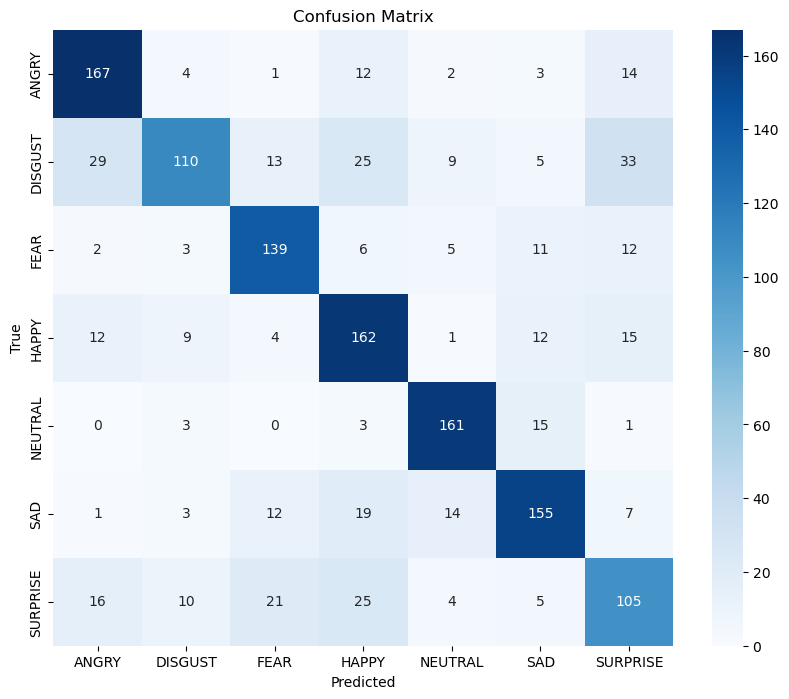

In [4]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


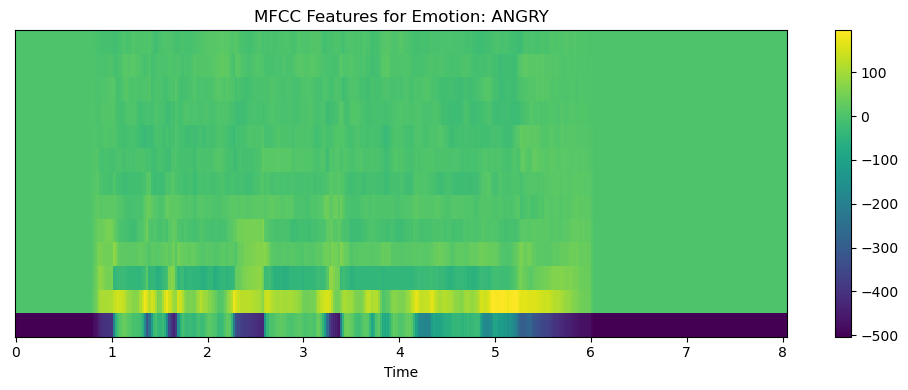

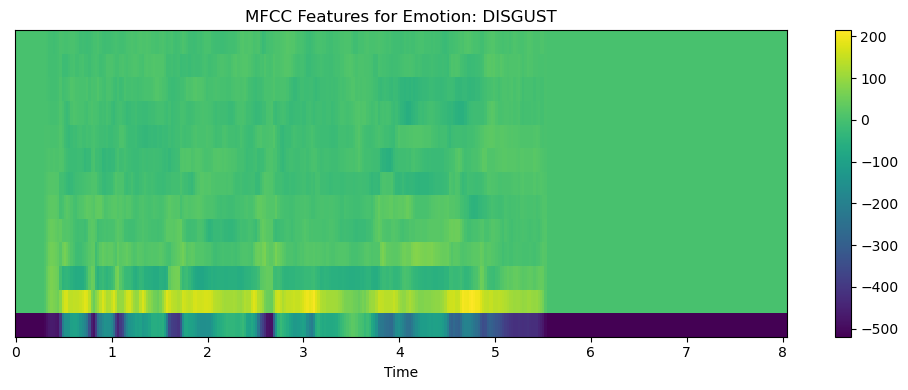

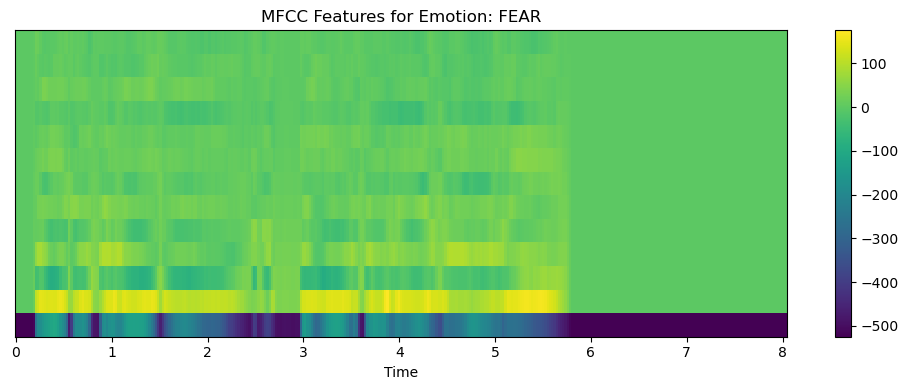

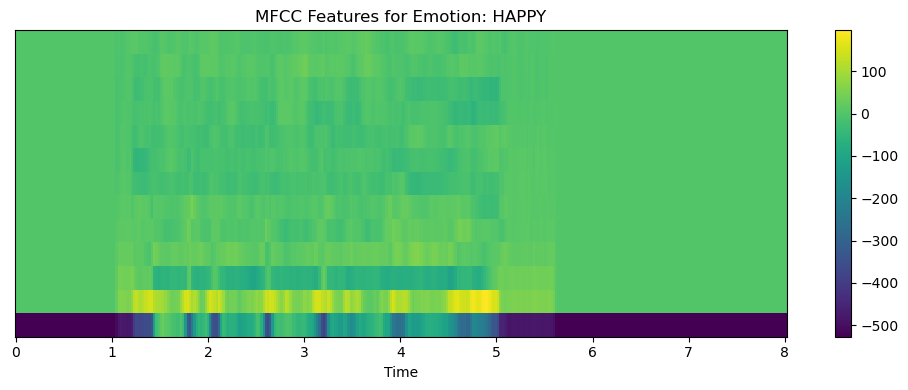

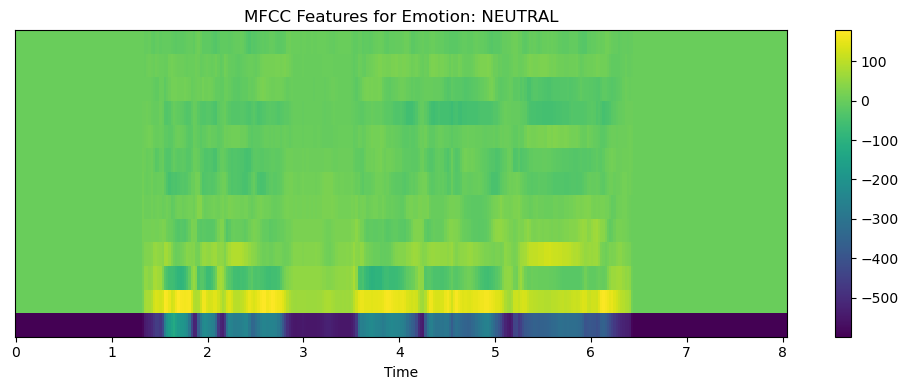

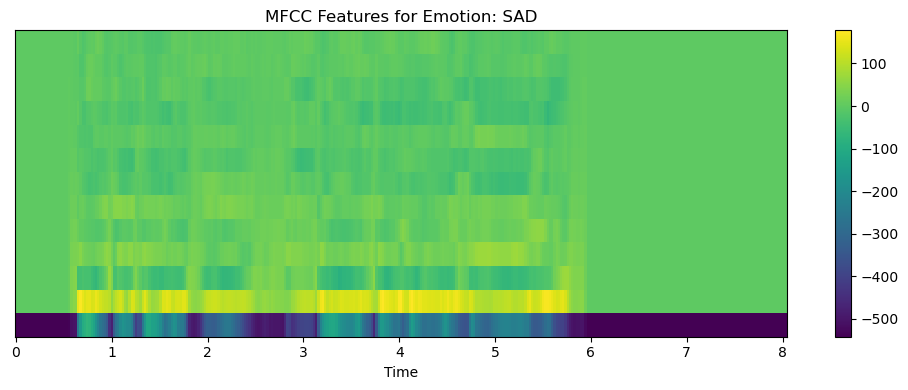

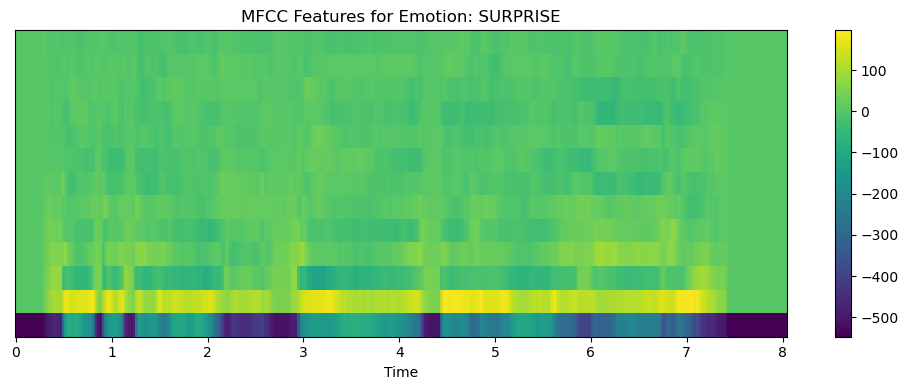

In [8]:
for emotion in os.listdir(data_path):
    emotion_folder = os.path.join(data_path, emotion)
    if os.path.isdir(emotion_folder):
        file = os.listdir(emotion_folder)[0]  # Take one example file from each class
        file_path = os.path.join(emotion_folder, file)
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mfcc, x_axis='time', cmap='viridis')
        plt.colorbar()
        plt.title(f"MFCC Features for Emotion: {emotion}")
        plt.tight_layout()
        plt.show()


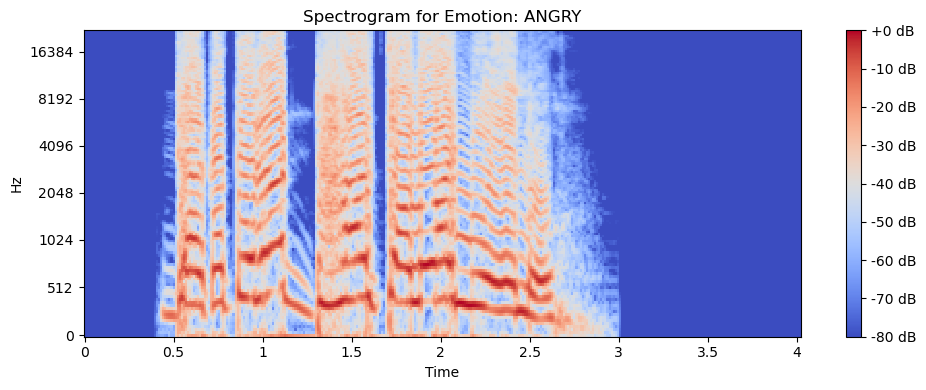

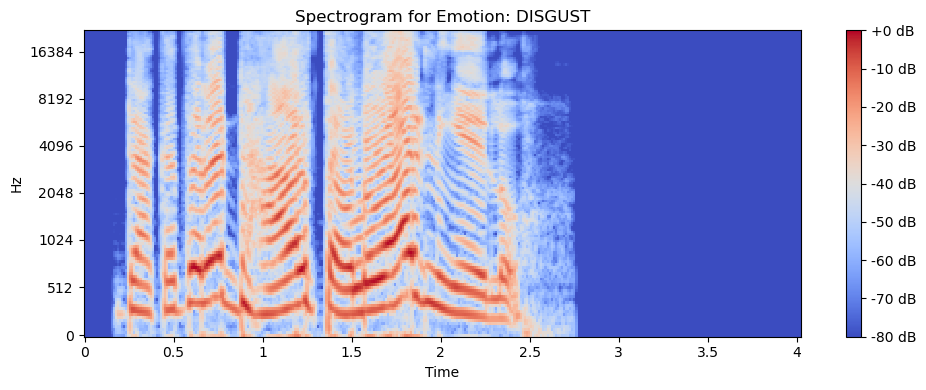

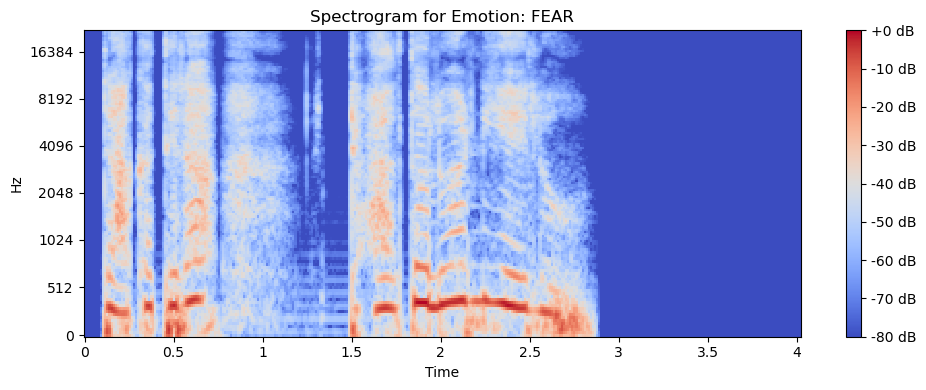

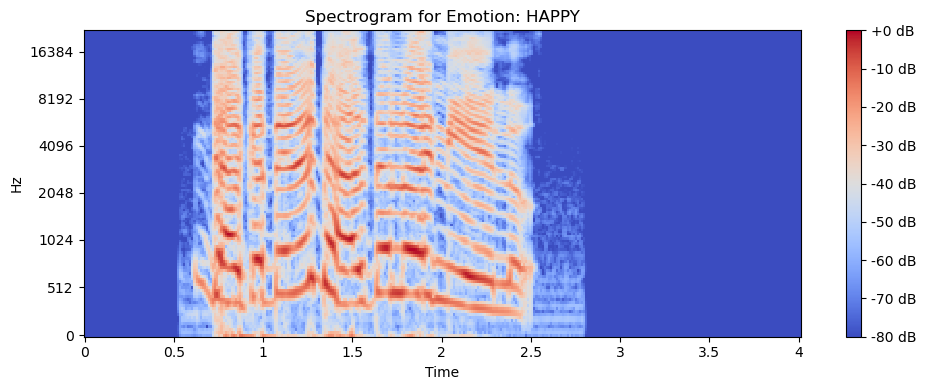

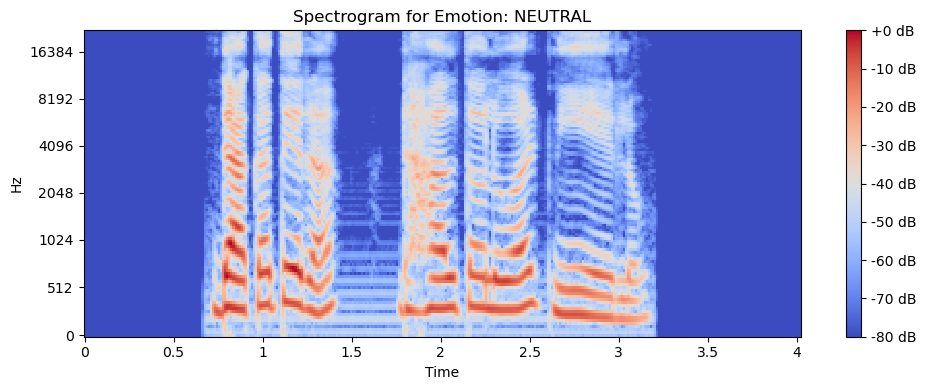

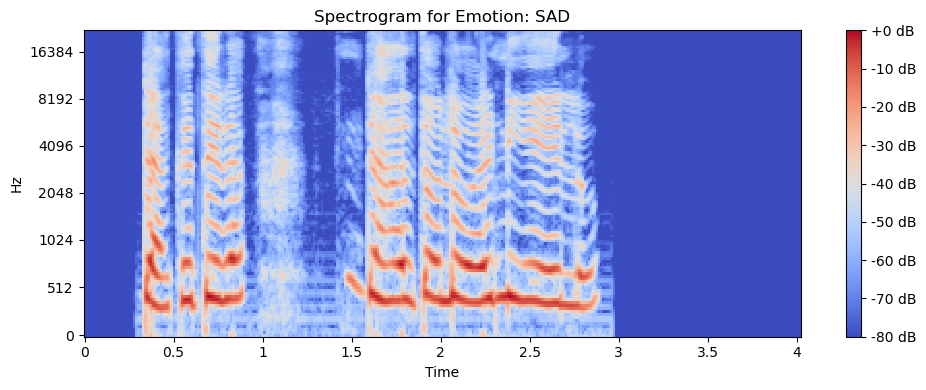

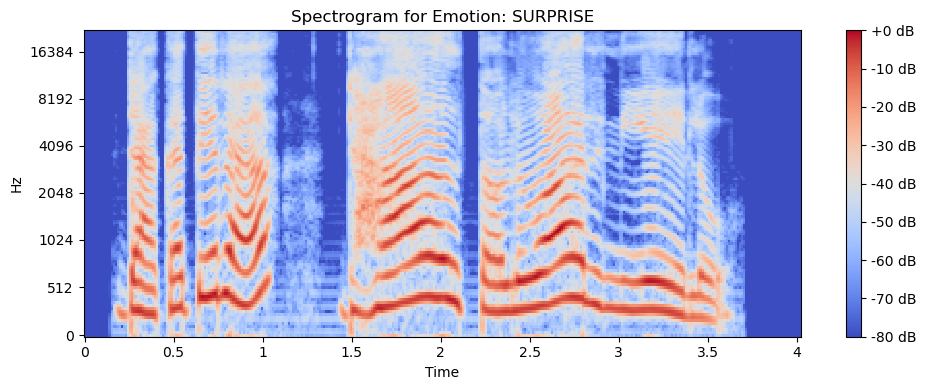

In [9]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Path to dataset
data_path = 'F:/MS Thesis/SUBESCO/Dataset'

# Function to generate and display spectrogram
def plot_spectrogram(file_path, emotion):
    y, sr = librosa.load(file_path, sr=None)  # Load audio file
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)  # Mel spectrogram
    S_dB = librosa.power_to_db(S, ref=np.max)  # Convert to decibels

    # Plot spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Spectrogram for Emotion: {emotion}")
    plt.tight_layout()
    plt.show()

# Generate spectrograms for one example from each emotion class
for emotion in os.listdir(data_path):
    emotion_folder = os.path.join(data_path, emotion)
    if os.path.isdir(emotion_folder):
        example_file = os.listdir(emotion_folder)[0]  # Pick the first audio file
        file_path = os.path.join(emotion_folder, example_file)
        plot_spectrogram(file_path, emotion)


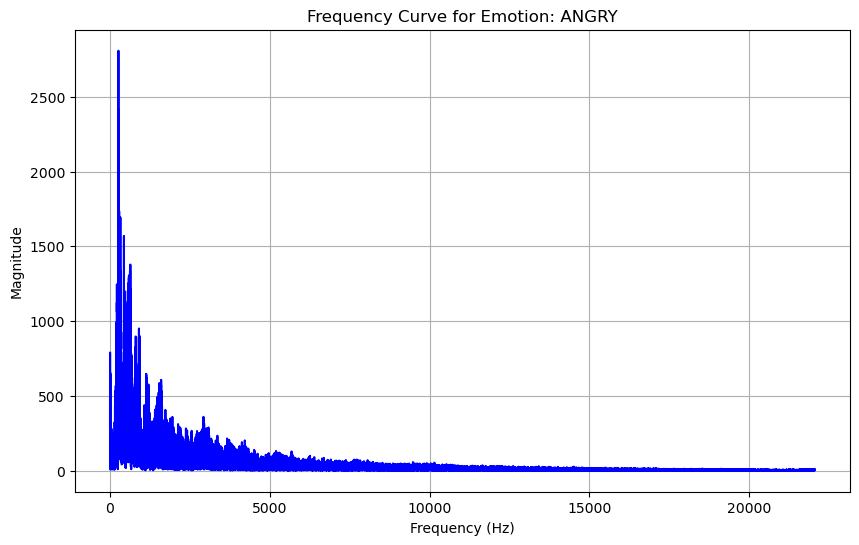

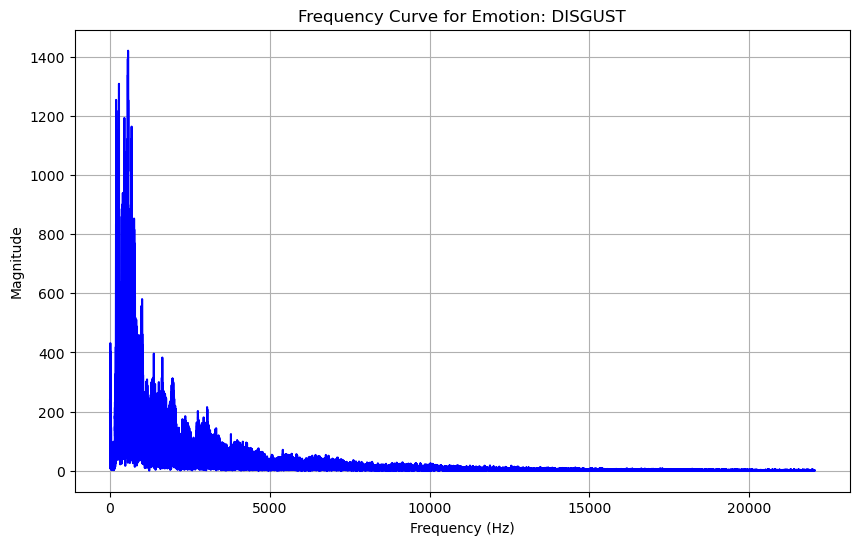

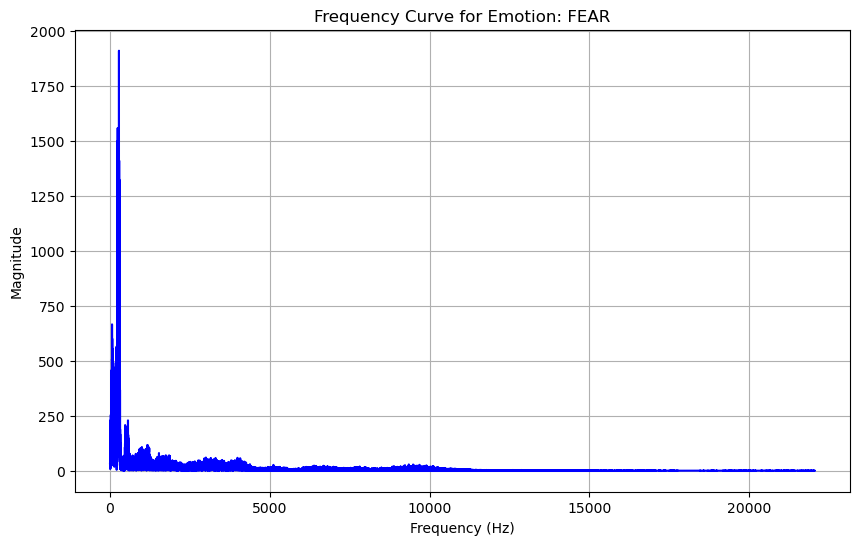

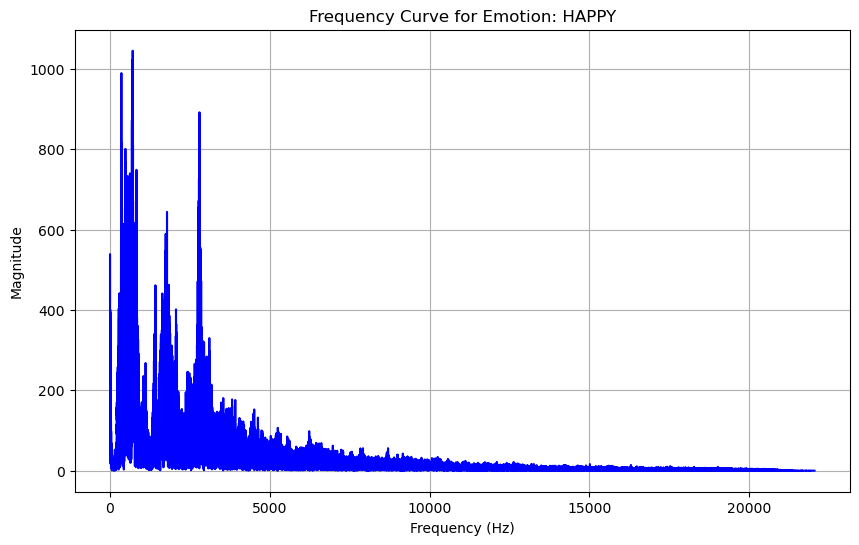

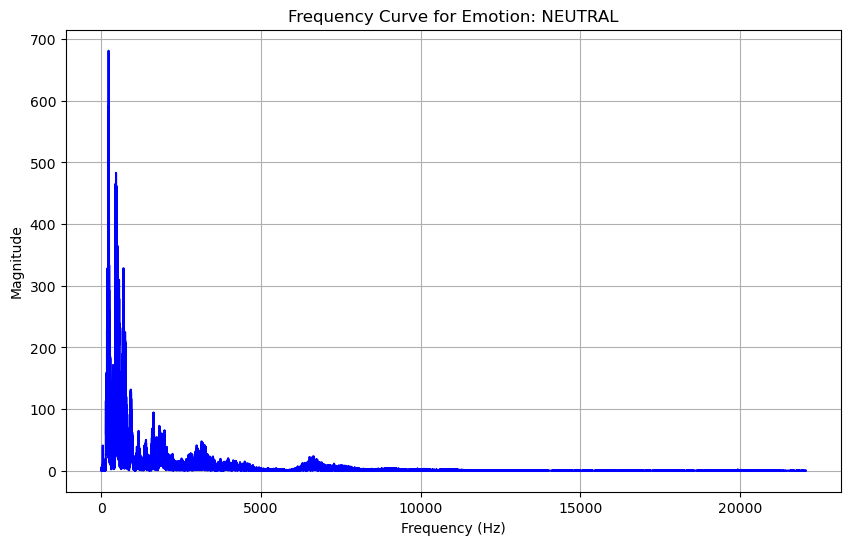

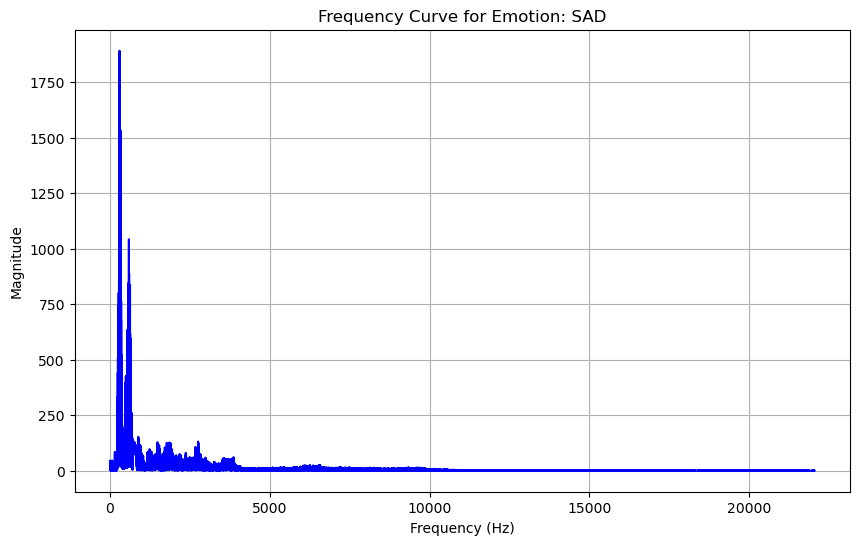

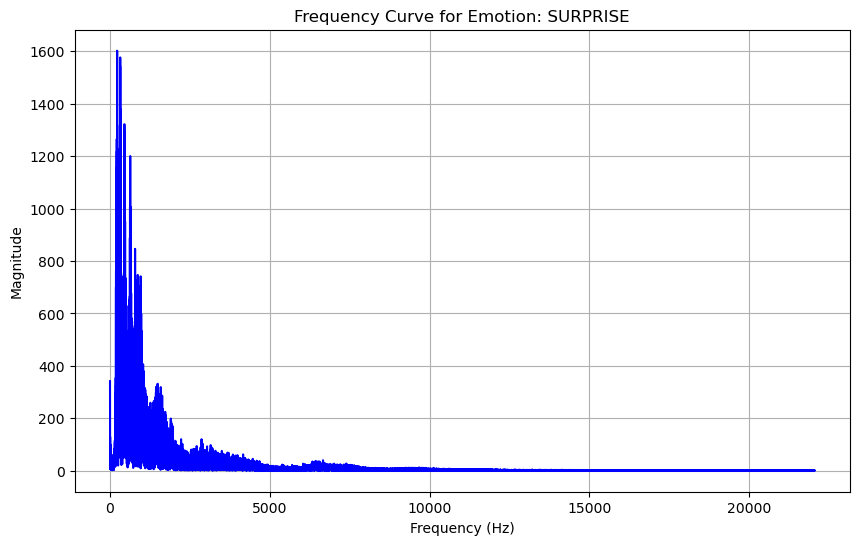

In [10]:
import os
import librosa
import matplotlib.pyplot as plt

# Path to dataset
data_path = 'F:/MS Thesis/SUBESCO/Dataset'

# Function to plot frequency curve
def plot_frequency_curve(file_path, emotion):
    y, sr = librosa.load(file_path, sr=None)  # Load audio file
    fft = np.fft.fft(y)  # Compute Fast Fourier Transform (FFT)
    magnitude = np.abs(fft)  # Magnitude of FFT
    frequency = np.linspace(0, sr, len(magnitude))  # Frequency range

    # Only keep the positive frequencies (real part of FFT)
    half_length = len(magnitude) // 2
    magnitude = magnitude[:half_length]
    frequency = frequency[:half_length]

    # Plot frequency curve
    plt.figure(figsize=(10, 6))
    plt.plot(frequency, magnitude, color='blue')
    plt.title(f"Frequency Curve for Emotion: {emotion}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid()
    plt.show()

# Generate frequency curves for one example from each emotion class
for emotion in os.listdir(data_path):
    emotion_folder = os.path.join(data_path, emotion)
    if os.path.isdir(emotion_folder):
        example_file = os.listdir(emotion_folder)[0]  # Pick the first audio file
        file_path = os.path.join(emotion_folder, example_file)
        plot_frequency_curve(file_path, emotion)
